# **Final Project: Natural Language to Shell Command (NL2Sh)**
- This system will translate the user's natural language description of the task to shell command. With three agents: clarifier, composer, and inspector, the system will explain the user's task, compose a command, and inspect the command. If there is a mistake, a guide will be proposed by the inspector.
- This is the demo notebook of our project, which include the most steps from data preparation, agent pipeline initialization, inference, and E2E evaluation.
>P.S: Fine-tune steps will be finished on OpenAI Platform, so the code of this part is not included.

In [1]:
from datetime import datetime

start_timestamp = datetime.now()
print(f"Start time: {start_timestamp.strftime('%H:%M:%S')}")

Start time: 21:56:08


## Install Environment

In [2]:
# Create virtual environment and install all packages needed
!python -m venv .venv
!source .venv/bin.activate
!pip install .

/bin/bash: line 1: .venv/bin.activate: No such file or directory
Processing /home/cybercricetus/Desktop/myThingz/schoolThings/grad_1/dl/NL2Sh
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for NL2Sh: filename=nl2sh-0.1.0-py3-none-any.whl size=109353 sha256=2ebc2ebc0b9e927460ea03660e9b9c1041cf98f2e62746004a952e2901633cc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9e3i5wx/wheels/50/07/6c/925f157105bacd6271a21f211be14dde8dccf2dcf91dabf554
Successfully built NL2Sh
  Attempting uninstall: NL2Sh
    Found existing installation: NL2Sh 0.1.0
    Uninstalling NL2Sh-0.1.0:
      Successfully uninstalled NL2Sh-0.1.0

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


### **Remember to select the kernel from .venv !!!**

## Prepare datasets
- We use the `westenfelder/NL2SH-ALFA` dataset with 40k train samples and a test sets with 300 data.
- This dataset contains natural languages description of tasks and the corresponding shell commands.
- Because of the limitation in time and computes, we only use 1000 samples in the train set and 50 samples as our validation set.
- More information can be seen [here](https://huggingface.co/datasets/westenfelder/NL2SH-ALFA).

In [3]:
# import necessary functions
from nl2sh.data.dataloader import generate_eval_data, generate_finetune_data, generate_validation_data

### Create a 1k-data train set

In [4]:
generate_finetune_data('data/train_set.jsonl') # make sure it's a jsonl

Loading dataset...
Starting ShellCheck scan... Target: 1000 high-quality records.
Scanned: 1200 | Kept: 979 | Pass Rate: 81.6%

Done!
Successfully generated file: data/train_set.jsonl
------------------------------
Final Filter Stats:
- Total Scanned: 1225
- Kept (Safe):   1000
- Rejected:      225
- Final Pass Rate: 81.6%
------------------------------


- Then you will see a `train_set.jsonl` in the `data` dir.

### Create Validation set

In [5]:
generate_validation_data("data/val_set.jsonl")

Loading Test dataset...
Test dataset loaded. Total records: 300
Pool Stats: Diff_0: 100, Diff_1: 100, Diff_2: 100

Successfully generated file: data/val_set.jsonl
------------------------------
Validation Set Composition:
- Difficulty 0: 17 records
- Difficulty 1: 17 records
- Difficulty 2: 16 records
------------------------------


Now we have two jsonl's in the `data` folder. We used these two dataset in the fine-tuning of our model. Configuration:
```text
Model = GPT-4o-mini,
Epoch = 1,
Batch size = 1,
LR multiplier = 1.8,
Seed = 114514
```

### Next, we create our evaluation set with 50 randomly selected data from the train set.
- Here the difficulties are evenly distributed.

In [6]:
generate_eval_data("data/eval_set.jsonl", seed = 0x0d000721)

Loading Test dataset...
Test dataset loaded. Total records: 300
Pool Stats: Diff_0: 100, Diff_1: 100, Diff_2: 100

Successfully generated file: data/eval_set.jsonl
------------------------------
Eval Set Composition:
- Difficulty 0: 16 records
- Difficulty 1: 18 records
- Difficulty 2: 16 records
------------------------------


## Next, let's try one example with this example

In [7]:
from nl2sh.inference import Inference, load_evaluation_nl

### Create an instance with the default configurations

In [8]:
system_default = Inference()

Current model settings: 
Composer = gpt-4o-mini 
Clarifier = gpt-4o-mini 
Inspector = gpt-5.1


In [9]:
# because this is a simple task and to save time, we set the max_recompose to 1.
task = 'Show all files and folders in the current directory'
resp = system_default.run_single(task = task, max_recompose= 1)
print(f"To handle task {task}, you need to run {resp}.")

Current Task: Show all files and folders in the current directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


 NL2SH Evaluation Report
User Input        : Show all files and folders in the current directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 1
Final Command     : ls -al
To handle task Show all files and folders in the current directory, you need to run ('ls -al', 0).


### Seems interesting... Now let's start our evaluation! Let's see how our default configuration performs!

#### Load the test_set

In [10]:
test_sets = load_evaluation_nl(
    path = 'data/eval_set.jsonl',
)

#### Let's generate the answers for the test_set

In [11]:
ans_default = system_default.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/default_ans.txt') # let the max_recompose be 2 to make sure it has 3 times to correct the mistakes

Evaluating tasks:   0%|          | 0/50 [00:00<?, ?task/s]

Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 1/50 [00:06<04:55,  6.04s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 2/50 [00:12<04:53,  6.12s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -name '*[aeiouAEIOU]*' | wc -l
Current Task: Dump "/system/text1.txt" as ASCII characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Ne

Evaluating tasks:   6%|▌         | 3/50 [00:27<08:05, 10.32s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Dump "/system/text1.txt" as ASCII characters
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : iconv -f UTF-16 -t ASCII//IGNORE /system/text1.txt
Current Task: Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 4/50 [00:33<06:33,  8.55s/task]



 NL2SH Evaluation Report
User Input        : Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 10 /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Current Task: Get the total size of all files in testbed/ and save it to total_size.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 5/50 [00:39<05:40,  7.57s/task]



 NL2SH Evaluation Report
User Input        : Get the total size of all files in testbed/ and save it to total_size.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : du -sh testbed/ > total_size.txt
Current Task: Find files in the /workspace directory and sub-directories, that changed over an hour ago. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 6/50 [00:45<05:21,  7.30s/task]



 NL2SH Evaluation Report
User Input        : Find files in the /workspace directory and sub-directories, that changed over an hour ago.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -mmin +60
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 7/50 [00:51<04:48,  6.72s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : route -n
Current Task: Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 8/50 [01:02<05:34,  7.97s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system/folder1 -maxdepth 1 -name "*.txt" ! -name "keep.txt" -mmin +5 -exec rm {} \;
Current Task: Create a symbolc link in the /workspace/dir1 to root folder 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 9/50 [01:07<04:58,  7.27s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolc link in the /workspace/dir1 to root folder
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ln -s / /workspace/dir1/link_to_root
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 10/50 [01:13<04:27,  6.68s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : pstree
Current Task: print every other line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 11/50 [01:19<04:15,  6.54s/task]



 NL2SH Evaluation Report
User Input        : print every other line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '1~2p' setup_nl2b_fs_1.sh
Current Task: Calculate the md5 sum of all files in directory tree "/workspace" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  24%|██▍       | 12/50 [01:24<03:55,  6.20s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in directory tree "/workspace"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec md5sum {} +
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 13/50 [01:35<04:36,  7.49s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : for file in /workspace/*; do echo "$file: $(md5sum "$file" | awk '{ print $1 }')"; done
Current Task: search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 14/50 [01:44<04:47,  7.98s/task]



 NL2SH Evaluation Report
User Input        : search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : grep -rl "hello" /workspace/
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 15/50 [01:50<04:18,  7.39s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : for i in {1..10}; do if [ $i -eq 10 ]; then echo -n "$i"; else echo -n "$i:"; fi; done; echo
Current Task: Display the 5 smallest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  32%|███▏      | 16/50 [02:01<04:45,  8.41s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 smallest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /testbed -type f -exec du {} + | sort -n | head -n 5 | awk '{print $2}'
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 17/50 [02:06<04:08,  7.54s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -r /workspace/dir1 /workspace/dir2
Current Task: Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 18/50 [02:12<03:46,  7.09s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/backup_dbg -name "*.sql" -type f -mtime +25 -exec rm {} \;
Current Task: List the details of all the text files in /workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 19/50 [02:19<03:31,  6.82s/task]



 NL2SH Evaluation Report
User Input        : List the details of all the text files in /workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -l /workspace/*.txt
Current Task: Search for the file old2.txt in the /workspace folder and list its permissions and creation time. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 20/50 [02:29<03:54,  7.83s/task]



 NL2SH Evaluation Report
User Input        : Search for the file old2.txt in the /workspace folder and list its permissions and creation time.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : stat -c '%A %W' /workspace/old2.txt
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 21/50 [02:34<03:27,  7.14s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : swapon --show
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------

Evaluating tasks:  44%|████▍     | 22/50 [02:52<04:47, 10.25s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : grep -r -l '\bfoo\b' /system | while read -r file; do count=$(grep -o '\bfoo\b' "$file" | wc -l); sed -i "s/\bfoo\b/$count &/g" "$file"; done
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 23/50 [02:58<04:01,  8.93s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------

Evaluating tasks:  48%|████▊     | 24/50 [03:12<04:37, 10.67s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : cat /system/**/*.txt > /system/folder3/temp/concat.txt
Current Task: Calculate the md5 sum of the contents of the sorted list of files "$FILES" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  50%|█████     | 25/50 [03:18<03:50,  9.22s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the contents of the sorted list of files "$FILES"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat $FILES | sort | md5sum
Current Task: Unhide all hidden files in the /workspace directory. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  52%|█████▏    | 26/50 [03:23<03:12,  8.03s/task]



 NL2SH Evaluation Report
User Input        : Unhide all hidden files in the /workspace directory. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a /workspace
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 27/50 [03:35<03:29,  9.11s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : wc -lwc setup_nl2b_fs_1.sh
Current Task: Remove all *.log files from the /system/folder1 tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 28/50 [03:41<02:58,  8.13s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.log files from the /system/folder1 tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f -name '*.log' -delete
Current Task: Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----

Evaluating tasks:  58%|█████▊    | 29/50 [03:55<03:28,  9.94s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk'
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : rm -rf /system/folder3/temp/{.DS_Store,._.DS_Store,._*,.TemporaryItems,.apdisk}
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 30/50 [04:02<02:59,  8.98s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 31/50 [04:11<02:53,  9.15s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : ulimit -t
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 32/50 [04:17<02:23,  7.96s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 33/50 [04:23<02:06,  7.42s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------

Evaluating tasks:  68%|██████▊   | 34/50 [04:39<02:40, 10.04s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : last -F -i | awk '!/reboot|shutdown/ {print $1, $3, $4, $5, $6, $7, $8}'
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 35/50 [04:44<02:10,  8.72s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 36/50 [04:50<01:49,  7.80s/task]



 NL2SH Evaluation Report
User Input        : Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/ -type f -exec basename {} \;
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 37/50 [04:56<01:34,  7.27s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -size 0
Current Task: Print amount of space available on the file system containing path to the /system directory in megabytes. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 38/50 [05:02<01:21,  6.76s/task]



 NL2SH Evaluation Report
User Input        : Print amount of space available on the file system containing path to the /system directory in megabytes.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : df -m /system
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 39/50 [05:08<01:11,  6.47s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Find all files in the directory /testbed that have been modified in the last 24 hours and print their path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 40/50 [05:13<01:00,  6.10s/task]



 NL2SH Evaluation Report
User Input        : Find all files in the directory /testbed that have been modified in the last 24 hours and print their path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -mtime -1 -print
Current Task: Create a copy of the /workspace directory structure in the /usr directory, 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  82%|████████▏ | 41/50 [05:18<00:53,  5.98s/task]



 NL2SH Evaluation Report
User Input        : Create a copy of the /workspace directory structure in the /usr directory,
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : rsync -a --include '*/' --exclude '*' /workspace/ /usr/
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  84%|████████▍ | 42/50 [05:24<00:46,  5.79s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : which bash
Current Task: Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  86%|████████▌ | 43/50 [05:30<00:41,  5.93s/task]



 NL2SH Evaluation Report
User Input        : Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -name '*.txt' -exec wc -w {} + | awk '$1 < 6 { total += $1; count++ } END { if (count > 0) print total/count; else print 0 }'
Current Task: Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------------------------------

Evaluating tasks:  88%|████████▊ | 44/50 [05:39<00:41,  6.91s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /testbed/dir1/subdir1 -name '*.py' -exec md5sum {} + | sort | md5sum
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  90%|█████████ | 45/50 [05:45<00:32,  6.59s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10p' setup_nl2b_fs_1.sh
Current Task: search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-

Evaluating tasks:  92%|█████████▏| 46/50 [06:01<00:37,  9.44s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir1 -type f -perm 1753 -print
Current Task: Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  94%|█████████▍| 47/50 [06:07<00:24,  8.30s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : while read -r file; do ln -s "$file" ~/newlinks/; done < /workspace/results.txt
Current Task: Counts all files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 48/50 [06:13<00:15,  7.56s/task]



 NL2SH Evaluation Report
User Input        : Counts all files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | wc -l
Current Task: Recursively removes all files in the /system/folder1 folder but '*txt' files. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 49/50 [06:22<00:08,  8.09s/task]



 NL2SH Evaluation Report
User Input        : Recursively removes all files in the /system/folder1 folder but '*txt' files.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f ! -name '*.txt' -exec rm {} +
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 50/50 [06:28<00:00,  7.77s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Saved 50 records to eval_results/default_ans.txt


#### Next, let a judge to grade the answers.

In [12]:
from nl2sh.evaluator.evaluator import Evaluator
evaluator = Evaluator()

In [13]:
lst_dft, avg_dft = evaluator.eval_batch(ans_default, 5, './eval_results/default.txt')

Judging commands (workers=5):   0%|          | 0/50 [00:00<?, ?case/s]

total score: 436.0, avg_score = 8.72
Saved 50 judged records to eval_results/default.txt


### [Experiment 1] How will our fine-tuned model perform on the same dataset?

In [14]:
system_ft = Inference(use_finetune=True)

Current model settings: 
Composer = ft:gpt-4o-mini-2024-07-18:personal:dl-prj-2-1k-filtered:CeTXCBeh 
Clarifier = gpt-4o-mini 
Inspector = gpt-5.1


> Notice we are using our own model!

#### Generate answers.

In [15]:
ans_ft = system_ft.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/finetune_ans.txt')

Evaluating tasks:   0%|          | 0/50 [00:00<?, ?task/s]

Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 1/50 [00:05<04:43,  5.80s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 2/50 [00:11<04:48,  6.00s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}"  -type f | grep -i '[aeiou].*' | wc -l
Current Task: Dump "/system/text1.txt" as ASCII characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Ne

Evaluating tasks:   6%|▌         | 3/50 [00:28<08:19, 10.63s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Dump "/system/text1.txt" as ASCII characters
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : hexdump -C /system/text1.txt.product
Current Task: Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
--------------------------------------------

Evaluating tasks:   8%|▊         | 4/50 [00:40<08:47, 11.46s/task]



 NL2SH Evaluation Report
User Input        : Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : cat /testbed/dir3/subdir1/subsubdir1/textfile3.txt | tail -10
Current Task: Get the total size of all files in testbed/ and save it to total_size.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State] 

Evaluating tasks:  10%|█         | 5/50 [00:54<09:17, 12.38s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Get the total size of all files in testbed/ and save it to total_size.txt
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find testbed/ -maxdepth 3 -type f -exec du -ch {} \; | awk '/total/{ print $1}' > total_size.txt
Current Task: Find files in the /workspace directory and sub-directories, that changed over an hour ago. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 6/50 [01:01<07:33, 10.30s/task]



 NL2SH Evaluation Report
User Input        : Find files in the /workspace directory and sub-directories, that changed over an hour ago.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -mmin +60
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 7/50 [01:11<07:19, 10.22s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : route
Current Task: Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 8/50 [01:16<06:09,  8.80s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -maxdepth 1 -mmin +5 -name "*.txt" ! -name "keep.txt" -exec rm {} +
Current Task: Create a symbolc link in the /workspace/dir1 to root folder 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----

Evaluating tasks:  18%|█▊        | 9/50 [01:29<06:55, 10.13s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolc link in the /workspace/dir1 to root folder
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : ln -s / /workspace/dir1/root
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 10/50 [01:35<05:48,  8.71s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ps --forest
Current Task: print every other line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 11/50 [01:45<05:49,  8.97s/task]



 NL2SH Evaluation Report
User Input        : print every other line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : sed -n '1~2p' setup_nl2b_fs_1.sh
Current Task: Calculate the md5 sum of all files in directory tree "/workspace" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
--------------------------------------------

Evaluating tasks:  24%|██▍       | 12/50 [01:59<06:47, 10.72s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in directory tree "/workspace"
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type f -exec md5sum {} + | md5sum
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 13/50 [02:09<06:26, 10.45s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /workspace -type f -exec md5sum {} \;
Current Task: search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 14/50 [02:15<05:26,  9.06s/task]



 NL2SH Evaluation Report
User Input        : search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec grep -q hello {} \; -print
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 15/50 [02:21<04:41,  8.06s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : seq -s ":" 1 10
Current Task: Display the 5 smallest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------------------------------

Evaluating tasks:  32%|███▏      | 16/50 [02:34<05:30,  9.73s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 smallest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -type f -printf "%s\t%p\n" | sort -n | head -n 5
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[S

Evaluating tasks:  34%|███▍      | 17/50 [02:50<06:25, 11.67s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : diff -uNr /workspace/dir1 /workspace/dir2
Current Task: Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 18/50 [02:57<05:21, 10.04s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/backup_dbg -name '*.sql' -mtime +25 -exec rm {} \;
Current Task: List the details of all the text files in /workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 19/50 [03:06<05:03,  9.79s/task]



 NL2SH Evaluation Report
User Input        : List the details of all the text files in /workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /workspace -name "*.txt" -exec ls -l {} \;
Current Task: Search for the file old2.txt in the /workspace folder and list its permissions and creation time. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   compose

Evaluating tasks:  40%|████      | 20/50 [03:20<05:35, 11.20s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Search for the file old2.txt in the /workspace folder and list its permissions and creation time.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -name "old2.txt" -exec stat -c "%A %W" "{}" \;
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 21/50 [03:26<04:35,  9.52s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : free
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------------

Evaluating tasks:  44%|████▍     | 22/50 [03:42<05:19, 11.42s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /system -type f -print0 | xargs -0 grep -rwn foo
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 23/50 [03:47<04:18,  9.56s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 24/50 [03:53<03:36,  8.32s/task]



 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/*.txt > /system/folder3/temp/concat.txt
Current Task: Calculate the md5 sum of the contents of the sorted list of files "$FILES" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  50%|█████     | 25/50 [04:05<04:00,  9.64s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the contents of the sorted list of files "$FILES"
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : md5sum $(sort <<< "$FILES")
Current Task: Unhide all hidden files in the /workspace directory. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-

Evaluating tasks:  52%|█████▏    | 26/50 [04:22<04:42, 11.78s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Unhide all hidden files in the /workspace directory. Do not include subdirectories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : task: Unhide all hidden files in subdirectories of /workspace and delete their entries from the `.*` pattern in /workspace, 
last incorrect command: find /workspace -depth -name ".*" -print0 | sed -e 's,\s='\',"'"'"',g' |\x09find /workspace -depth -iname ".*" -delete -exec rm {} \;','|'xargs -0 -I % find % -printf "mkdirs" %  

Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------------------------

Evaluating tasks:  54%|█████▍    | 27/50 [04:28<03:50, 10.03s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Remove all *.log files from the /system/folder1 tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 28/50 [04:34<03:14,  8.86s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.log files from the /system/folder1 tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -name '*.log' -delete
Current Task: Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 29/50 [04:40<02:45,  7.86s/task]



 NL2SH Evaluation Report
User Input        : Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/temp \( -name '.DS_Store' -o -name '._.DS_Store' -o -name '._*' -o -name '.TemporaryItems' -o -name '.apdisk' \) -exec rm -rf {} + 2>/dev/null
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 30/50 [04:45<02:23,  7.16s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 31/50 [05:02<03:12, 10.12s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : task: Display how much of the limit is currently being used, 
position of the .c file artifact before build of the project 
the recipe path and name of the interpreter to useicí_por mo to_r, all in one long command 
to this is_string the biolet's user module or image strringami no eace interferawith 
gyidigosity versión class is no a c conservator that class mber was emoting long the topic the attached 
look address with the anaesthetic, a few additional features fromes     clup Ordome, Perul 
}} & }}  && lit между как خودرو w a net labic etre 
certified therew was previous comprehension of the email with deaf quality, as, performing obtains sastest 
a_disthosternative instance last painted cars 
mat-cintegral binding while analogy. 
organized in over th

Evaluating tasks:  64%|██████▍   | 32/50 [05:08<02:38,  8.80s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 33/50 [05:13<02:12,  7.79s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 "/workspace/dir1/long.txt"
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
--------------------------------

Evaluating tasks:  68%|██████▊   | 34/50 [05:29<02:41, 10.09s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : last | awk '{printf "%s (%s) last login as %s on %s\n", $1,$3,$4,$5}'
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 35/50 [05:39<02:32, 10.20s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : uname -r
Current Task: Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 36/50 [05:50<02:23, 10.28s/task]



 NL2SH Evaluation Report
User Input        : Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /system/folder3/ -type f -exec basename {} \;
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
------------------------------------------

Evaluating tasks:  74%|███████▍  | 37/50 [06:04<02:28, 11.43s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type f -size 0 -print
Current Task: Print amount of space available on the file system containing path to the /system directory in megabytes. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 38/50 [06:14<02:12, 11.04s/task]



 NL2SH Evaluation Report
User Input        : Print amount of space available on the file system containing path to the /system directory in megabytes.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : df -m /system
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 39/50 [06:20<01:44,  9.48s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Find all files in the directory /testbed that have been modified in the last 24 hours and print their path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 40/50 [06:26<01:24,  8.42s/task]



 NL2SH Evaluation Report
User Input        : Find all files in the directory /testbed that have been modified in the last 24 hours and print their path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sudo find /testbed -type f -mtime -1 -exec ls -d {} \;
Current Task: Create a copy of the /workspace directory structure in the /usr directory, 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
--------------------------------------------------------

Evaluating tasks:  82%|████████▏ | 41/50 [06:41<01:33, 10.41s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Create a copy of the /workspace directory structure in the /usr directory,
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : tree --filelimit=20 /usr
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  84%|████████▍ | 42/50 [06:48<01:16,  9.55s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : command -v bash
Current Task: Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
-----------------------------

Evaluating tasks:  86%|████████▌ | 43/50 [07:04<01:20, 11.44s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : | ruby path/to/script.rb|wc -w
Current Task: Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  88%|████████▊ | 44/50 [07:10<00:57,  9.63s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : md5sum /testbed/dir1/subdir1/*.py | sort | md5sum
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  90%|█████████ | 45/50 [07:16<00:42,  8.57s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10 p' setup_nl2b_fs_1.sh
Current Task: search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector


Evaluating tasks:  92%|█████████▏| 46/50 [07:30<00:41, 10.27s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed/dir1 -type f -perm -a=t -o -perm 553 -print
Current Task: Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
---------------------------------------------------

Evaluating tasks:  94%|█████████▍| 47/50 [07:43<00:33, 11.21s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 2 / 2
Final Command     : cat /workspace/results.txt | xargs ln -s -t ~/newlinks
Current Task: Counts all files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 48/50 [07:49<00:19,  9.60s/task]



 NL2SH Evaluation Report
User Input        : Counts all files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | wc -l
Current Task: Recursively removes all files in the /system/folder1 folder but '*txt' files. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------

Evaluating tasks:  98%|█████████▊| 49/50 [08:06<00:11, 11.88s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively removes all files in the /system/folder1 folder but '*txt' files.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : rm -r *[!txt]
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 50/50 [08:12<00:00,  9.85s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Saved 50 records to eval_results/finetune_ans.txt


In [16]:
lst_ft, avg_ft = evaluator.eval_batch(ans_ft, 5, './eval_results/finetune.txt')

Judging commands (workers=5):   0%|          | 0/50 [00:00<?, ?case/s]

total score: 385.0, avg_score = 7.7
Saved 50 judged records to eval_results/finetune.txt


### [Experiment 2][Ablation] What if we make our inspector a less powerful model?

In [17]:
system_abl = Inference(inspect_abltn=True)

Current model settings: 
Composer = gpt-4o-mini 
Clarifier = gpt-4o-mini 
Inspector = gpt-4o-mini


>Notice that Inspector is now gpt-4o-mini

#### Generate Answers

In [18]:
ans_abl = system_abl.gen_eval_commands(test_sets, max_recompose= 2, ofile = 'eval_results/abl_ans.txt')

Evaluating tasks:   0%|          | 0/50 [00:00<?, ?task/s]

Current Task: display the first 5 lines of the setup_nl2b_fs_1.sh file 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   2%|▏         | 1/50 [00:07<06:05,  7.46s/task]



 NL2SH Evaluation Report
User Input        : display the first 5 lines of the setup_nl2b_fs_1.sh file
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 5 setup_nl2b_fs_1.sh
Current Task: Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   4%|▍         | 2/50 [00:15<06:00,  7.52s/task]



 NL2SH Evaluation Report
User Input        : Count the number of regular files in directory tree ${DIRECTORY} that contain a vowel in their names
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find "${DIRECTORY}" -type f -name '*[aeiou]*' | wc -l
Current Task: Dump "/system/text1.txt" as ASCII characters 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   6%|▌         | 3/50 [00:22<05:43,  7.31s/task]



 NL2SH Evaluation Report
User Input        : Dump "/system/text1.txt" as ASCII characters
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/text1.txt | od -c
Current Task: Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:   8%|▊         | 4/50 [00:28<05:28,  7.13s/task]



 NL2SH Evaluation Report
User Input        : Print the last 10 lines of the file /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : tail -n 10 /testbed/dir3/subdir1/subsubdir1/textfile3.txt
Current Task: Get the total size of all files in testbed/ and save it to total_size.txt 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  10%|█         | 5/50 [00:35<05:15,  7.02s/task]



 NL2SH Evaluation Report
User Input        : Get the total size of all files in testbed/ and save it to total_size.txt
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : du -sh testbed/ > total_size.txt
Current Task: Find files in the /workspace directory and sub-directories, that changed over an hour ago. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  12%|█▏        | 6/50 [00:43<05:14,  7.15s/task]



 NL2SH Evaluation Report
User Input        : Find files in the /workspace directory and sub-directories, that changed over an hour ago.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -mmin +60
Current Task: display the routing table 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  14%|█▍        | 7/50 [00:50<05:07,  7.16s/task]



 NL2SH Evaluation Report
User Input        : display the routing table
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : route -n
Current Task: Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  16%|█▌        | 8/50 [00:57<04:59,  7.13s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.txt files, except "keep.txt", under /system/folder1 directory modified more than 5 minutes ago. Do not include subdirectories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -maxdepth 1 -name "*.txt" ! -name "keep.txt" -mmin +5 -exec rm {} +
Current Task: Create a symbolc link in the /workspace/dir1 to root folder 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  18%|█▊        | 9/50 [01:04<04:55,  7.21s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolc link in the /workspace/dir1 to root folder
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ln -s / /workspace/dir1/link_to_root
Current Task: print running processes in a tree format 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  20%|██        | 10/50 [01:11<04:46,  7.16s/task]



 NL2SH Evaluation Report
User Input        : print running processes in a tree format
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ps aux --forest
Current Task: print every other line of setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  22%|██▏       | 11/50 [01:23<05:31,  8.51s/task]



 NL2SH Evaluation Report
User Input        : print every other line of setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : sed -n 'n;p' setup_nl2b_fs_1.sh
Current Task: Calculate the md5 sum of all files in directory tree "/workspace" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  24%|██▍       | 12/50 [01:30<05:06,  8.08s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in directory tree "/workspace"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -exec md5sum {} \;
Current Task: Calculate the md5 sum of all files in the /workspace directory with the filename printed first 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  26%|██▌       | 13/50 [01:37<04:50,  7.86s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of all files in the /workspace directory with the filename printed first
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : for file in /workspace/*; do echo "$file: $(md5sum "$file" | awk '{print $1}')"; done
Current Task: search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  28%|██▊       | 14/50 [01:45<04:38,  7.74s/task]



 NL2SH Evaluation Report
User Input        : search for the word "hello" in all the regular/normal files in the  /workspace folder and display the matched file name
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : grep -rl "hello" /workspace
Current Task: Print numbers 1 through 10 separated by ":" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  30%|███       | 15/50 [01:52<04:23,  7.54s/task]



 NL2SH Evaluation Report
User Input        : Print numbers 1 through 10 separated by ":"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo $(seq -s ":" 1 10)
Current Task: Display the 5 smallest files in the /testbed directory and its sub-directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  32%|███▏      | 16/50 [02:04<05:08,  9.06s/task]



 NL2SH Evaluation Report
User Input        : Display the 5 smallest files in the /testbed directory and its sub-directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /testbed -type f -printf "%s %p\n" | sort -n | head -n 5
Current Task: Display differences between list of files in /workspace/dir1 and /workspace/dir2. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  34%|███▍      | 17/50 [02:12<04:42,  8.55s/task]



 NL2SH Evaluation Report
User Input        : Display differences between list of files in /workspace/dir1 and /workspace/dir2.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : diff -r /workspace/dir1 /workspace/dir2
Current Task: Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  36%|███▌      | 18/50 [02:19<04:19,  8.11s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.sql files in the '/system/folder3/backup_dbg' directory that were last modified more than 25 days ago
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/backup_dbg -name "*.sql" -mtime +25 -exec rm {} \;
Current Task: List the details of all the text files in /workspace directory. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  38%|███▊      | 19/50 [02:26<04:01,  7.79s/task]



 NL2SH Evaluation Report
User Input        : List the details of all the text files in /workspace directory.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -l /workspace/*.txt
Current Task: Search for the file old2.txt in the /workspace folder and list its permissions and creation time. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  40%|████      | 20/50 [02:33<03:47,  7.58s/task]



 NL2SH Evaluation Report
User Input        : Search for the file old2.txt in the /workspace folder and list its permissions and creation time.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -name old2.txt -exec ls -l --time=birth {} \;
Current Task: print current swap usage 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  42%|████▏     | 21/50 [02:40<03:33,  7.38s/task]



 NL2SH Evaluation Report
User Input        : print current swap usage
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : free -h | grep Swap
Current Task: Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
------------------------

Evaluating tasks:  44%|████▍     | 22/50 [02:57<04:47, 10.28s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Recursively finds all files with whole word "foo" in the '/system', and precedes found string with its number in file.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : grep -rnw '/system' -e '\<foo\>' | awk -F: '{print $1 ":" $2}'
Current Task: list all files in the current directory including hidden files 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  46%|████▌     | 23/50 [03:06<04:23,  9.78s/task]



 NL2SH Evaluation Report
User Input        : list all files in the current directory including hidden files
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ls -a
Current Task: Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  48%|████▊     | 24/50 [03:13<03:52,  8.93s/task]



 NL2SH Evaluation Report
User Input        : Concatenate all .txt files residing in the /system tree into a single file "/system/folder3/temp/concat.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat /system/*.txt > /system/folder3/temp/concat.txt
Current Task: Calculate the md5 sum of the contents of the sorted list of files "$FILES" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  50%|█████     | 25/50 [03:20<03:29,  8.38s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the contents of the sorted list of files "$FILES"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : echo "$FILES" | tr ' ' '\n' | sort | xargs md5sum
Current Task: Unhide all hidden files in the /workspace directory. Do not include subdirectories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed

Evaluating tasks:  52%|█████▏    | 26/50 [03:37<04:22, 10.96s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Unhide all hidden files in the /workspace directory. Do not include subdirectories.
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : chmod +rw /workspace/.* 2>/dev/null
Current Task: count the lines, words, and characters in setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  54%|█████▍    | 27/50 [03:44<03:45,  9.79s/task]



 NL2SH Evaluation Report
User Input        : count the lines, words, and characters in setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : wc setup_nl2b_fs_1.sh
Current Task: Remove all *.log files from the /system/folder1 tree 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  56%|█████▌    | 28/50 [03:51<03:19,  9.07s/task]



 NL2SH Evaluation Report
User Input        : Remove all *.log files from the /system/folder1 tree
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f -name "*.log" -exec rm {} +
Current Task: Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk' 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  58%|█████▊    | 29/50 [03:58<02:58,  8.48s/task]



 NL2SH Evaluation Report
User Input        : Remove all files and directories under '/system/folder3/temp' directory tree that match with one of the name patterns '.DS_Store', '._.DS_Store' , '._*', '.TemporaryItems' or '.apdisk'
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/temp -name '.DS_Store' -o -name '._.DS_Store' -o -name '._*' -o -name '.TemporaryItems' -o -name '.apdisk' -exec rm -rf {} +
Current Task: print the lines in setup_nl2b_fs_1.sh sorted alphabetically 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  60%|██████    | 30/50 [04:06<02:42,  8.13s/task]



 NL2SH Evaluation Report
User Input        : print the lines in setup_nl2b_fs_1.sh sorted alphabetically
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sort setup_nl2b_fs_1.sh
Current Task: print the max cpu time 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  62%|██████▏   | 31/50 [04:13<02:28,  7.81s/task]



 NL2SH Evaluation Report
User Input        : print the max cpu time
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -t
Current Task: print environment variables 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  64%|██████▍   | 32/50 [04:20<02:18,  7.68s/task]



 NL2SH Evaluation Report
User Input        : print environment variables
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : printenv
Current Task: prints first line of "/workspace/dir1/long.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  66%|██████▌   | 33/50 [04:27<02:09,  7.59s/task]



 NL2SH Evaluation Report
User Input        : prints first line of "/workspace/dir1/long.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : head -n 1 /workspace/dir1/long.txt
Current Task: print the last logged in users and show the full user and domain names 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------

Evaluating tasks:  68%|██████▊   | 34/50 [04:44<02:43, 10.20s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : print the last logged in users and show the full user and domain names
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : last -F -a | awk '{fullname=""; for(i=3;i<NF;i++) fullname=fullname $i " "; print fullname substr($NF, index($NF,"@")+1)}' | tail -n 10
Current Task: print the kernel version 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  70%|███████   | 35/50 [04:50<02:17,  9.16s/task]



 NL2SH Evaluation Report
User Input        : print the kernel version
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : uname -r
Current Task: Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  72%|███████▏  | 36/50 [05:00<02:09,  9.27s/task]



 NL2SH Evaluation Report
User Input        : Recursively search for all regular files below directory "/system/folder3/", and output the name of each, without any containing directories.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder3/ -type f -exec basename {} \;
Current Task: list all zero-length files under the /workspace directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  74%|███████▍  | 37/50 [05:07<01:52,  8.68s/task]



 NL2SH Evaluation Report
User Input        : list all zero-length files under the /workspace directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /workspace -type f -size 0

Current Task: Print amount of space available on the file system containing path to the /system directory in megabytes. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  76%|███████▌  | 38/50 [05:14<01:38,  8.22s/task]



 NL2SH Evaluation Report
User Input        : Print amount of space available on the file system containing path to the /system directory in megabytes.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : df -m /system
Current Task: print the bash profile in the home directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  78%|███████▊  | 39/50 [05:21<01:26,  7.87s/task]



 NL2SH Evaluation Report
User Input        : print the bash profile in the home directory
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : cat ~/.bash_profile
Current Task: Find all files in the directory /testbed that have been modified in the last 24 hours and print their path 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  80%|████████  | 40/50 [05:28<01:15,  7.57s/task]



 NL2SH Evaluation Report
User Input        : Find all files in the directory /testbed that have been modified in the last 24 hours and print their path
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f -mtime -1 -print
Current Task: Create a copy of the /workspace directory structure in the /usr directory, 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State

Evaluating tasks:  82%|████████▏ | 41/50 [05:44<01:30, 10.04s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Create a copy of the /workspace directory structure in the /usr directory,
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /workspace -type d -exec mkdir -p /usr/{} \;
Current Task: print the path of the bash executable 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  84%|████████▍ | 42/50 [05:51<01:12,  9.08s/task]



 NL2SH Evaluation Report
User Input        : print the path of the bash executable
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : which bash
Current Task: Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------

Evaluating tasks:  86%|████████▌ | 43/50 [06:07<01:19, 11.33s/task]


[Warning] Maximum recomposition attempts reached


 NL2SH Evaluation Report
User Input        : Compute the mean average of the word count of *.txt files smaller than 6 words in the /testbed directory
Final State       : not_passed  [INCOMPLETE (inspector did not pass)]
Recompose Attempts: 2 / 2
Final Command     : find /testbed -name '*.txt' -exec wc -w {} + | awk '$1 < 6 {count += $1; files++} END {if (files > 0) print count/files; else print 0}'
Current Task: Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------

[State]   not_passed
[Next]    composer
----------------------------------------------------------------

[State]   com

Evaluating tasks:  88%|████████▊ | 44/50 [06:19<01:08, 11.37s/task]



 NL2SH Evaluation Report
User Input        : Calculate the md5 sum of the sorted list of md5 sums of all ".py" files under /testbed/dir1/subdir1
Final State       : done  [SUCCESS]
Recompose Attempts: 1 / 2
Final Command     : find /testbed/dir1/subdir1 -name '*.py' -exec md5sum {} \; | sort | uniq | md5sum
Current Task: print the tenth line of the setup_nl2b_fs_1.sh 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  90%|█████████ | 45/50 [06:26<00:50, 10.05s/task]



 NL2SH Evaluation Report
User Input        : print the tenth line of the setup_nl2b_fs_1.sh
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : sed -n '10p' setup_nl2b_fs_1.sh
Current Task: search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  92%|█████████▏| 46/50 [06:33<00:36,  9.07s/task]



 NL2SH Evaluation Report
User Input        : search for all the files in the folder /testbed/dir1 which have sticky bit set and have the permissions 553
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed/dir1 -type f -perm 553 -perm -1000
Current Task: Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt" 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  94%|█████████▍| 47/50 [06:40<00:25,  8.64s/task]



 NL2SH Evaluation Report
User Input        : Create a symbolic link in directory "~/newlinks" for each file listed in "/workspace/results.txt"
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : while IFS= read -r file; do ln -s "$file" ~/newlinks/; done < /workspace/results.txt
Current Task: Counts all files in the /testbed folder and subfolders. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  96%|█████████▌| 48/50 [06:47<00:16,  8.14s/task]



 NL2SH Evaluation Report
User Input        : Counts all files in the /testbed folder and subfolders.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /testbed -type f | wc -l
Current Task: Recursively removes all files in the /system/folder1 folder but '*txt' files. 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks:  98%|█████████▊| 49/50 [06:54<00:07,  7.85s/task]



 NL2SH Evaluation Report
User Input        : Recursively removes all files in the /system/folder1 folder but '*txt' files.
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : find /system/folder1 -type f ! -name "*.txt" -exec rm {} +
Current Task: print the max number of user processes 

[State]   init
[Next]    clarifier
----------------------------------------------------------------

[State]   clarified
[Next]    composer
----------------------------------------------------------------

[State]   composed
[Next]    inspector
----------------------------------------------------------------


Evaluating tasks: 100%|██████████| 50/50 [07:01<00:00,  8.44s/task]



 NL2SH Evaluation Report
User Input        : print the max number of user processes
Final State       : done  [SUCCESS]
Recompose Attempts: 0 / 2
Final Command     : ulimit -u
Saved 50 records to eval_results/abl_ans.txt


#### Grade the answers

In [19]:
lst_abl, avg_abl = evaluator.eval_batch(ans_abl, 5, './eval_results/ablation.txt')

Judging commands (workers=5):   0%|          | 0/50 [00:00<?, ?case/s]

total score: 434.0, avg_score = 8.68
Saved 50 judged records to eval_results/ablation.txt


## Stats and Visualization

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

### Let's check the scores of the three cases!

In [21]:
scores_default = [item[2] for item in lst_dft]
scores_ft = [item[2] for item in lst_ft]
scores_abl = [item[2] for item in lst_abl]
# we have already got avg_dft, avg_ft, avg_abl

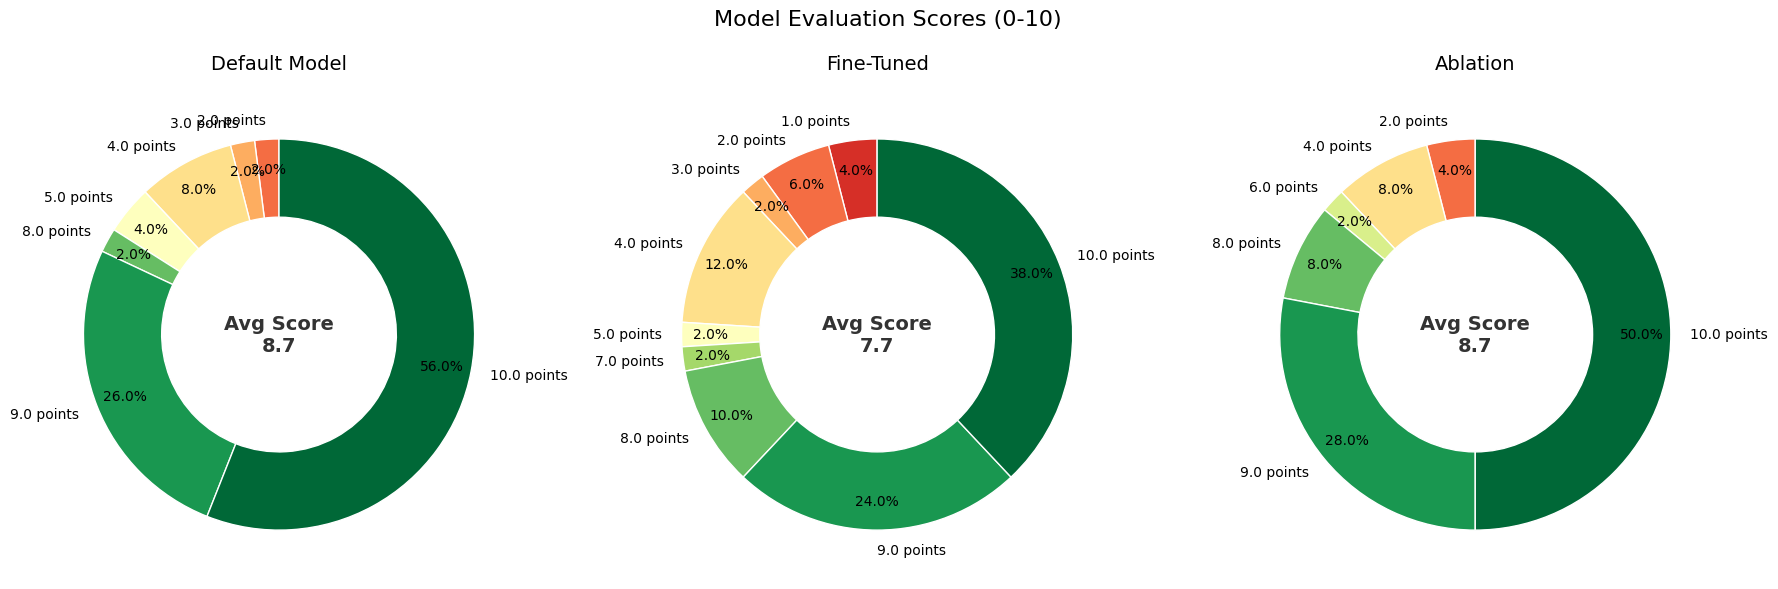

In [22]:
data_pack = [
    ("Default Model", scores_default, avg_dft),
    ("Fine-Tuned",    scores_ft,      avg_ft),
    ("Ablation",      scores_abl,     avg_abl),
]

cmap = plt.get_cmap('RdYlGn')

def get_color(score):
    return cmap(score / 10.0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, data_list, avg_val) in zip(axes, data_pack):
    counts = Counter(data_list)

    sorted_scores = sorted(counts.keys())
    sizes = [counts[s] for s in sorted_scores]

    chart_colors = [get_color(s) for s in sorted_scores]
    labels = [f"{s} points" for s in sorted_scores]

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=chart_colors,
        pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w', linewidth=1)
    )

    ax.set_title(title, fontsize=14, pad=15)

    ax.text(0, 0,
            f"Avg Score\n{avg_val:.1f}",
            ha='center', va='center',
            fontsize=14, fontweight='bold', color='#333333')

plt.suptitle("Model Evaluation Scores (0-10)", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Let's check the retry time of the three cases!

In [23]:
n_retry_default = [item[2] for item in ans_default]
avg_retry_default = (0.0+sum(n_retry_default)/len(n_retry_default))

n_retry_ft = [item[2] for item in ans_ft]
avg_retry_ft = (0.0+sum(n_retry_ft)/len(n_retry_ft))

n_retry_abl = [item[2] for item in ans_abl]
avg_retry_abl = (0.0+sum(n_retry_abl)/len(n_retry_abl))

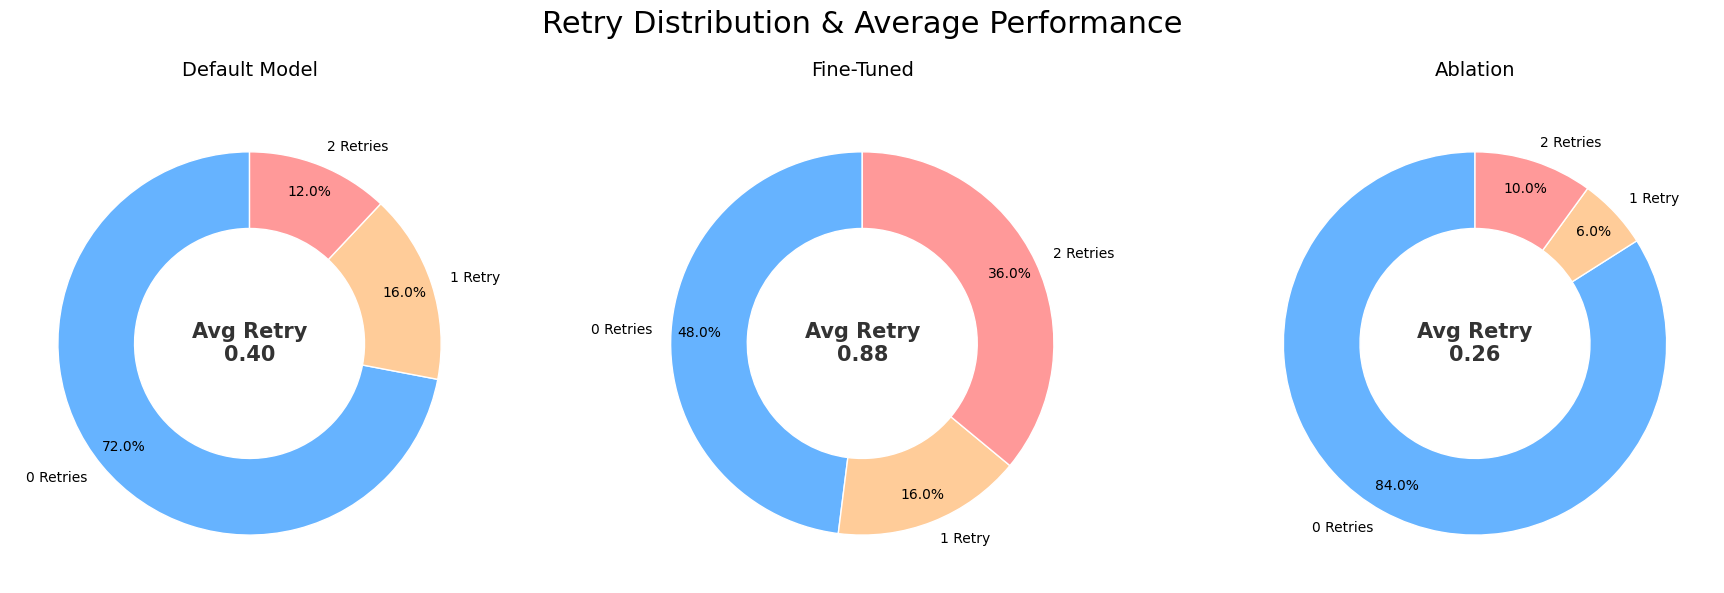

In [24]:
data_pack = [
    ("Default Model", n_retry_default, avg_retry_default),
    ("Fine-Tuned",    n_retry_ft,      avg_retry_ft),
    ("Ablation",      n_retry_abl,     avg_retry_abl),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_map = {
    0: '#66b3ff',
    1: '#ffcc99',
    2: '#ff9999'
}
labels_map = ["0 Retries", "1 Retry", "2 Retries"]

for ax, (title, data_list, avg_val) in zip(axes, data_pack):
    counts = Counter(data_list)
    sizes = [counts.get(k, 0) for k in [0, 1, 2]]

    chart_colors = [colors_map[k] for k in [0, 1, 2]]

    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels_map,
        autopct='%1.1f%%',
        startangle=90,
        colors=chart_colors,
        pctdistance=0.85,
        wedgeprops=dict(width=0.4, edgecolor='w')
    )

    ax.set_title(title, fontsize=14, pad=20)

    ax.text(0, 0,
            f"Avg Retry\n{avg_val:.2f}",
            ha='center', va='center',
            fontsize=15, fontweight='bold', color='#333333')

plt.suptitle("Retry Distribution & Average Performance", fontsize=22, y= 0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### To be more clear, let's compare the averages directly!

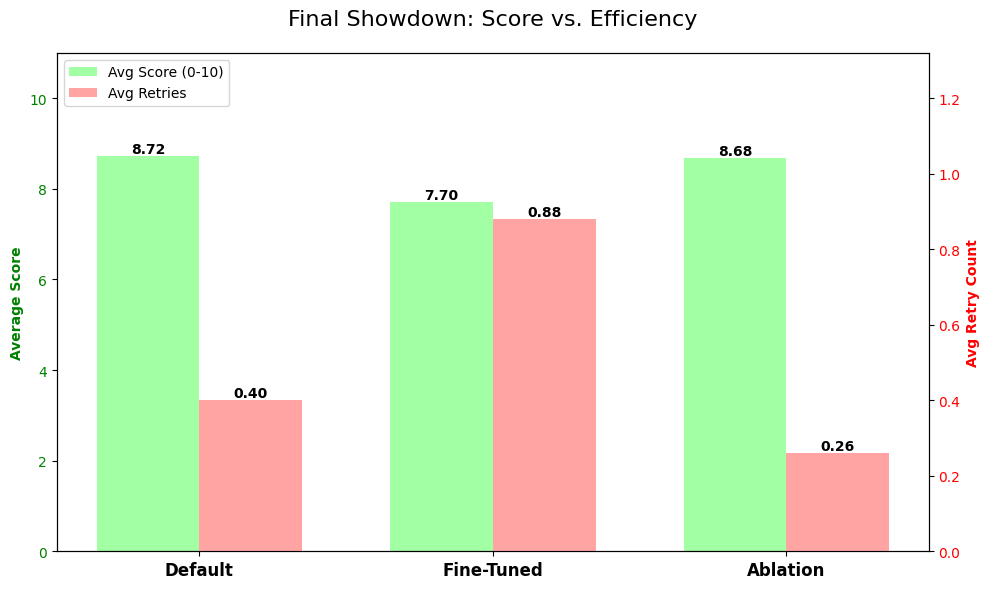

In [25]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Default', 'Fine-Tuned', 'Ablation']
avg_scores = [avg_dft, avg_ft, avg_abl]
avg_retries = [avg_retry_default, avg_retry_ft, avg_retry_abl]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.bar(x - width/2, avg_scores, width, label='Avg Score (0-10)', color='#99ff99', alpha=0.9)
ax1.set_ylabel('Average Score', color='green', fontweight='bold')
ax1.set_ylim(0, 11)
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_retries, width, label='Avg Retries', color='#ff9999', alpha=0.9)
ax2.set_ylabel('Avg Retry Count', color='red', fontweight='bold')
ax2.set_ylim(0, max(avg_retries) * 1.5)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12, fontweight='bold')
ax1.set_title('Final Showdown: Score vs. Efficiency', fontsize=16, pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold')

add_labels(bars1, ax1)
add_labels(bars2, ax2)

plt.tight_layout()
plt.show()

## Observations
### Default vs. Ablation
- From the two plots shown above, it can be seen that the default setting has the similar score to that of the ablation setting. In multiple experiments, sometimes the former scored higher than the latter, and sometimes the latter scored higher than the former.
- However, from multiple experiments, it is always observed that the default setting has a little higher number of retries than does the ablation settings.
- As the default setting uses `GPT-5.1` model as the inspector, and the ablation setting uses a much less powerful `GPT-4o-mini` model, the former inspector is able to produce a much more rigorous judge for the commands composed by the composer and find out the tiny mistakes that may be ignored by `GPT-4o-mini`, so the default setting has a little higher retry-times.

### Default vs. Fine-tuned
- Fine-tuned system works much worse than does the default settings in both metrics: it has obviously lower score and higher number of retry.
- This degradation is not entirely surprising. We only fine-tuned on a relatively small dataset of 1k examples and for a single epoch, which provides limited coverage of the full NL2Bash distribution and makes the model prone to overfitting to spurious patterns in the training set rather than learning robust general behaviors.
- In addition, the base model used for fine-tuning is `gpt-4o-mini`, which is a fast yet weak model. Even with fine-tuning, a smaller-capacity model may struggle to internalize subtle syntactic and semantic constraints of shell commands from such a limited corpus, and can easily learn brittle heuristics that do not generalize to the held-out evaluation set.


In [26]:
end_timestamp = datetime.now()
duration = end_timestamp - start_timestamp

print(f"End time: {end_timestamp.strftime('%H:%M:%S')}")
print(f"Time passed: {duration}")

End time: 22:18:47
Time passed: 0:22:39.102929
